In [1]:
# add ../ to the path so we can import the module
import sys
sys.path.append('../')
import helpers_for_backend as hfb

### Producing the pkl file

In [2]:
extracted_rules = hfb.load_rule_data('../dataset/rules_recipe_scale.csv', 'lift')

Starting to load rule data
Rule data loaded...

Starting rule extraction...
	 -> Starting to sort rules by lift
	 -> Done sorting rules...
______________________________


In [3]:
# relex examples
import pandas as pd
from gensim.parsing.preprocessing import preprocess_string
relex_examples = pd.read_csv('../dataset/relex_examples.csv')

relex_examples['preprocessed'] = relex_examples['recipe'].apply(preprocess_string)

In [4]:
import helper
import prompt_comparison_mp as pcm

prompt_functions = [
    helper.prompt_gpt_3,
    helper.prompt_gpt_3_extra_info,
    helper.prompt_gpt_short,
    helper.prompt_gpt_short_extra_info,
]

rule_counts = [1,3,5,10,30]

tasks = pcm.create_tasks(
    prompt_functions=prompt_functions,
    rule_counts=rule_counts,
    relex_examples=relex_examples,
    extracted_rules=extracted_rules,
)

In [5]:
mp_results = pcm.parallel_process(tasks)

Starting task 0
Starting task 1
Starting task 2
Starting task 3
Task 3 progress: 0.2
Task 0 progress: 0.2
Task 1 progress: 0.2
Task 2 progress: 0.2
Task 1 row: 22, rule count 3 Retry count: 1 failed due to HTTP code 502 from API (<html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>cloudflare</center>
</body>
</html>
)
Retrying...
Task 3 progress: 0.4
Task 1 progress: 0.4
Task 2 progress: 0.4
Task 0 progress: 0.4
Task 0 row: 138, rule count 10 Retry count: 1 failed due to Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)
Retrying...
Task 3 progress: 0.8
Task 1 progress: 0.8
Task 2 progress: 0.8
Task 0 progress: 0.8
Task 3 row: 95, rule count 30 Retry count: 1 failed due to HTTP code 502 from API (<html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>cloudflare</center>
</body>
</html>
)
Retrying...
Task 1 row: 104

In [15]:
final_dict = {}
for task in range(len(tasks)):
    final_dict.update(mp_results[task])

In [6]:
# save mp_results to pkl
import pickle
with open('mp_results.pkl', 'wb') as f:
    pickle.dump(mp_results, f)

In [18]:
with open('mp_results_flattened.pkl', 'wb') as f:
    pickle.dump(final_dict, f)

### Visualizing

In [2]:
# load final_dict from 'mp_results_flattened.pkl'
import pickle
with open('mp_results_flattened.pkl', 'rb') as f:
    final_dict = pickle.load(f)

In [7]:
all_prompting_functions = final_dict.keys()
all_prompting_functions

dict_keys(['prompt_gpt_3', 'prompt_gpt_3_extra_info', 'prompt_gpt_short', 'prompt_gpt_short_extra_info'])

In [9]:
all_rule_counts = final_dict['prompt_gpt_3'].keys()
all_rule_counts

dict_keys([1, 3, 5, 10, 30])

In [10]:
final_dict['prompt_gpt_3'][1]

[(0,
  "<RECIPE>\nIngredients:\n- 1 pound of hamburger meat\n- 16 oz chicken broth\n- A bag of frozen peas and carrots (or one canned of each)\n- A tablespoon or so of ketchup\n- Worcestershire to taste\n- Garlic salt, salt, pepper, and onion powder to taste\n- Potatoes\n- Butter\n- 1 cup of heavy cream\n\nInstructions:\n1. Brown 1 pound of hamburger meat. Drain the grease.\n2. Put hamburger meat into skillet with one 16 oz chicken broth, a bag of frozen peas and carrots (or one canned of each), a tablespoon or so of ketchup and Worcestershire to taste. Also add garlic salt, salt, pepper, and onion powder to taste. Bring to a boil.\n3. While this is boiling, peel and cut potatoes and boil them until tender with a fork. Drain the potatoes and put them back in the pot.\n4. Reduce the heat to low and let the meat mixture simmer until most of the liquid is gone.\n5. Mash the potatoes and add butter, salt and pepper, and 1 cup of heavy cream. Stir the potatoes and set them aside.\n6. Pour t

In [16]:
# Now we want to get the average number of rules fulfilled for each rule count for each prompt function, to this we do the following:
# Get all the results one prompt function and one rule count by doing: final_dict['prompt_gpt_3'][1]
# This means we are currently considering the prompt function 'prompt_gpt_3' and the rule count 1
# Then this gives us a list of tuples of the form: (recipe_id, recipe_itself, (number_of_rules_fulfilled, number_of_rules_not_fulfilled, percentage))
# We want to get the average number of rules fulfilled for each rule count for each prompt function, so we need to iterate over all the results for each prompt function and rule count
# We have all the prompt functions in all_prompting_functions and all the rule counts in all_rule_counts
# Create a dictionary to store the average number of rules fulfilled for each rule count for each prompt function
average_fulfillment = {}

# Iterate over each prompt function
for prompt_function in all_prompting_functions:
    # Create a dictionary to store the total number of rules fulfilled and not fulfilled for each rule count
    rule_counts = {}

    # Iterate over each rule count
    for rule_count in all_rule_counts:
        # Get all the results for the current prompt function and rule count
        results = final_dict[prompt_function][rule_count]

        # Initialize variables to store the total number of rules fulfilled and not fulfilled
        total_fulfilled = 0
        total_not_fulfilled = 0

        # Iterate over the results
        for _, _, (num_fulfilled, num_not_fulfilled, _) in results:
            total_fulfilled += num_fulfilled
            total_not_fulfilled += num_not_fulfilled

        # Calculate the average number of rules fulfilled for the current rule count
        average_fulfilled = total_fulfilled / (total_fulfilled + total_not_fulfilled)

        # Store the average number of rules fulfilled for the current rule count
        rule_counts[rule_count] = average_fulfilled

    # Store the rule counts and average fulfillment for the current prompt function
    average_fulfillment[prompt_function] = rule_counts



In [17]:
average_fulfillment

{'prompt_gpt_3': {1: 0.9621621621621622,
  3: 0.9240506329113924,
  5: 0.9066232356134636,
  10: 0.8674633351439435,
  30: 0.7793904208998549},
 'prompt_gpt_3_extra_info': {1: 0.9675675675675676,
  3: 0.9367088607594937,
  5: 0.9153094462540716,
  10: 0.8794133623030962,
  30: 0.7661465892597968},
 'prompt_gpt_short': {1: 0.9297297297297298,
  3: 0.8860759493670886,
  5: 0.8870792616720955,
  10: 0.8435632808256383,
  30: 0.7256894049346879},
 'prompt_gpt_short_extra_info': {1: 0.9567567567567568,
  3: 0.891500904159132,
  5: 0.9022801302931596,
  10: 0.8435632808256383,
  30: 0.760522496371553}}

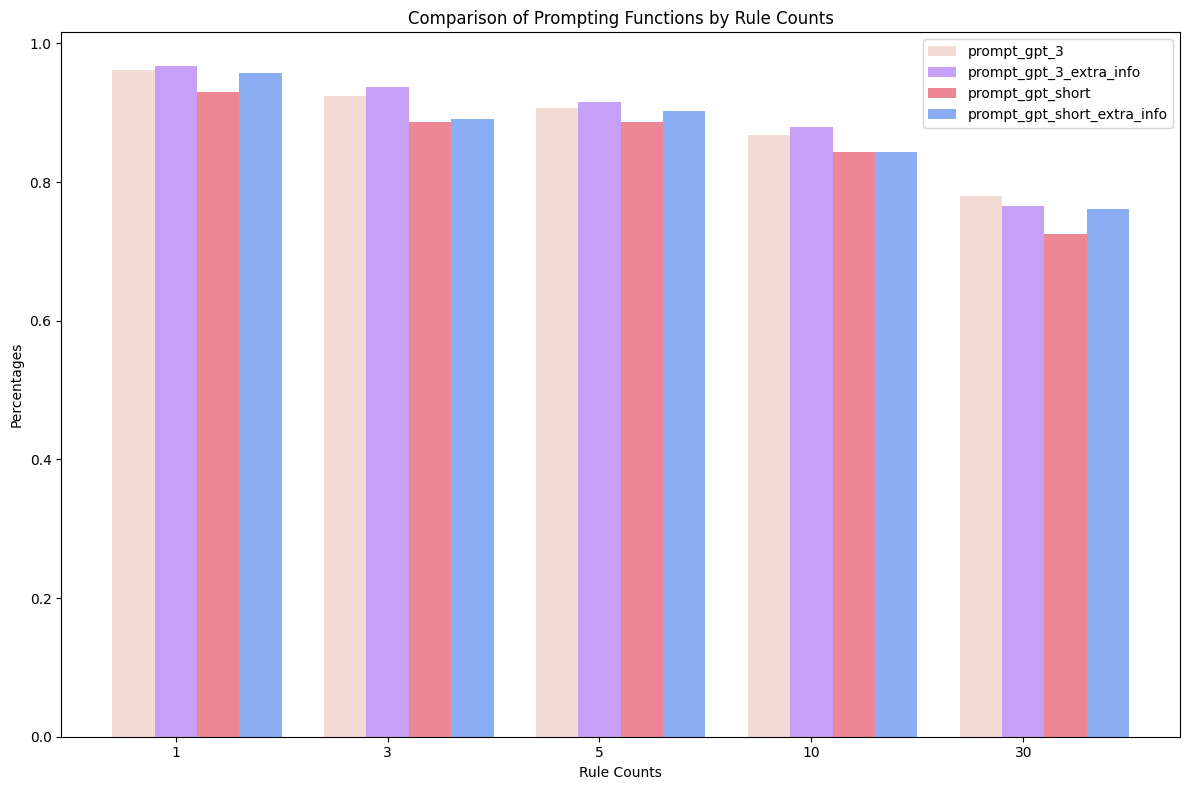

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Catppuccin color scheme
catppuccin_colors = ["#f4dbd6", "#c6a0f6", "#ed8796", "#8aadf4"]

# Number of groups and bar width
n_groups = len(all_rule_counts)
bar_width = 0.2

# Calculating positions for each group and bar
indices = np.arange(n_groups)
positions = [indices + bar_width*i for i in range(len(all_prompting_functions))]

# Plotting the bars with Catppuccin color scheme
plt.figure(figsize=(12, 8))
for i, prompt in enumerate(all_prompting_functions):
    plt.bar(positions[i], [average_fulfillment[prompt][count] for count in all_rule_counts], 
            bar_width, label=prompt, color=catppuccin_colors[i % len(catppuccin_colors)])


# Adding labels, title, and legend
plt.xlabel('Rule Counts')
plt.ylabel('Percentages')
plt.title('Comparison of Prompting Functions by Rule Counts')
plt.xticks(indices + bar_width, all_rule_counts)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()